# Adversarial Discriminative Domain Adaptation (ADDA)

This is the implementation for the following paper:
```
@inproceedings{tzeng2017adversarial,
  title={Adversarial discriminative domain adaptation},
  author={Tzeng, Eric and Hoffman, Judy and Saenko, Kate and Darrell, Trevor},
  booktitle={Proceedings of the IEEE conference on computer vision and pattern recognition},
  pages={7167--7176},
  year={2017}
}
```

The paper is also available [here](./res/Adversarial%20Discriminative%20Domain%20Adaptation.pdf).

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter

np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import _base_model
import _dataloader_helper

#### For logging multiple runs

In [3]:
import pathlib

log_root = pathlib.Path(f'./adda')
run_id = 1
while True:
    log_dir = log_root/f'run{run_id}'
    if not log_dir.exists():
        break
    run_id += 1

# use a previous run
# log_dir = log_root/'run1'
log_dir.mkdir(parents=True, exist_ok=True)
print(f'Logging to: {log_dir}')

Logging to: adda\run1


### Prepare dataset

Here, we transform both the source and target datasets into the same size, and repeat the channel dimension for grayscale images, such that both datasets have the same input shape to the model.

In [4]:
input_shape = (3, 32, 32)
num_classes = 10

loader_helper = _dataloader_helper.MNIST2USPS(image_size=input_shape[1:])
src_train, src_val, src_test = loader_helper.get_src_loaders()
tgt_train, tgt_val, tgt_test = loader_helper.get_tgt_loaders()

#### Visualize some samples from both domains

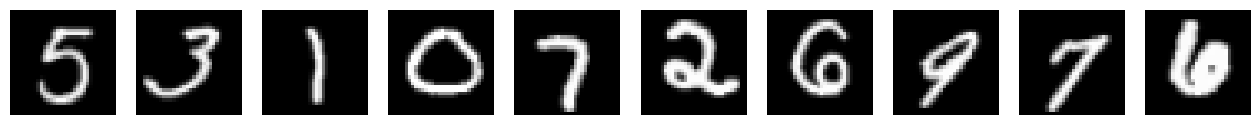

torch.Size([10, 3, 32, 32])
tensor([5, 3, 1, 0, 7, 2, 6, 9, 7, 6])


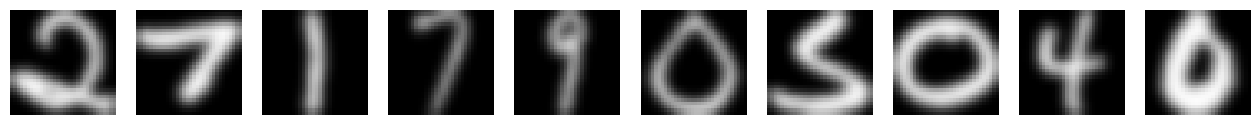

torch.Size([10, 3, 32, 32])
tensor([2, 7, 1, 7, 9, 0, 5, 0, 4, 0])


In [5]:
num_samples = 10

src_samples = next(iter(src_train))
tgt_samples = next(iter(tgt_train))

src_images, src_labels = src_samples[0][:num_samples], src_samples[1][:num_samples]
tgt_images, tgt_labels = tgt_samples[0][:num_samples], tgt_samples[1][:num_samples]

def plot_samples(samples, figsize=(16, 6)):
    fig, ax = plt.subplots(1, num_samples, figsize=figsize)
    for i in range(num_samples):
        ax[i].imshow(np.transpose(samples[i], (1, 2, 0)))
        ax[i].axis('off')
    plt.show()

plot_samples(src_images)
print(src_images.shape)
print(src_labels)

plot_samples(tgt_images)
print(tgt_images.shape)
print(tgt_labels)

## ADDA

The domain adaptation procedure by ADDA is shown in the figure below:<br>
<img src="./res/images/adda-overview.png" width="1000"/>

It consists of three main steps:
1. Train an entire classifier on the source domain.
2. Train a feature encoder on the target domain by adversarial training with the source domain feature encoder.
3. Combine the feature encoder on the target domain with the classifier trained on the source domain, to form the overall classifier for the target domain.

In Step. 2 above, the adversarial training is done by training a discriminator to distinguish between the source and target domain features, while training the target feature encoder to confuse the discriminator. This is given by the following optimization:
$$\begin{align*}
\min_{D} L_{\text{adv}_D} (\mathbf{X}_s, \mathbf{X}_t, M_s, M_t) &= -\mathbb{E}_{\mathbf{x}_s \sim \mathbf{X}_s} \log D(M_s(\mathbf{x}_s)) - \mathbb{E}_{\mathbf{x}_t \sim \mathbf{X}_t} \log (1 - D(M_t(\mathbf{x}_t))) \\
\min_{M_t} L_{\text{adv}_M} (\mathbf{X}_s, \mathbf{X}_t, D) &= -\mathbb{E}_{\mathbf{x}_t \sim \mathbf{X}_t} \log D(M_t(\mathbf{x}_t))
\end{align*}$$
where $D$ is the discriminator, $M_s$ and $M_t$ are the feature encoders for the source and target domains respectively, and $\mathbf{X}_s$ and $\mathbf{X}_t$ are the source and target domain datasets respectively.

### Step 1. Train the source classifier

#### Initialize the source classifier

In [6]:
src_model = _base_model.CNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

summary(src_model, input_size=(5, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [5, 10]                   --
├─CNNEncoder: 1-1                        [5, 128, 2, 2]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [5, 64, 15, 15]           1,792
│    │    └─Sequential: 3-2              [5, 128, 6, 6]            73,856
│    │    └─Sequential: 3-3              [5, 128, 2, 2]            147,584
├─FCHead: 1-2                            [5, 10]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [5, 3072]                 1,575,936
│    │    └─Sequential: 3-5              [5, 2048]                 6,293,504
│    │    └─Linear: 3-6                  [5, 10]                   20,490
Total params: 8,113,162
Trainable params: 8,113,162
Non-trainable params: 0
Total mult-adds (M): 121.73
Input size (MB): 0.06

#### Train on source domain

In [7]:
def evaluate(model, val_loader, loss_fn):
    val_loss = 0
    val_acc = 0

    training = model.training
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = loss_fn(y_pred, y).item()
            n_correct = (y_pred.argmax(dim=1) == y).sum().item()
            val_loss += loss * x.shape[0]
            val_acc += n_correct
    model.train(training)
    
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    return (val_loss, val_acc)

def train_src_model(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    num_steps=20000,
    checkpoint=100,
):
    model.train()

    train_stats = []
    val_stats = []
    best_val_loss = float('inf')

    tb_writer = SummaryWriter(log_dir=log_dir)
    train_iter = iter(train_loader)

    for step in tqdm(range(num_steps)):
        try:
            x, y = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            x, y = next(train_iter)
        x = x.to(device)
        y = y.to(device)

        y_pred, _ = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if checkpoint and step % checkpoint == 0:
            val_loss, val_acc = evaluate(model, val_loader, loss_fn)

            train_stats += [[step, loss.item()]]
            val_stats += [[step, val_loss, val_acc]]

            tb_writer.add_scalar('src-only/loss/train', loss.item(), step)
            tb_writer.add_scalar('src-only/loss/val', val_loss, step)
            tb_writer.add_scalar('src-only/acc/val', val_acc, step)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), log_dir/'src_best_model.pth')
    
    tb_writer.close()

    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

In [8]:
train_stats, val_stats = train_src_model(
    src_model,
    src_train,
    src_val,
    nn.CrossEntropyLoss(),
    torch.optim.Adam(src_model.parameters(), lr=1e-3),
    num_steps=2000,
    checkpoint=100,
)

100%|██████████| 2000/2000 [01:31<00:00, 21.90it/s]


#### Learning curves

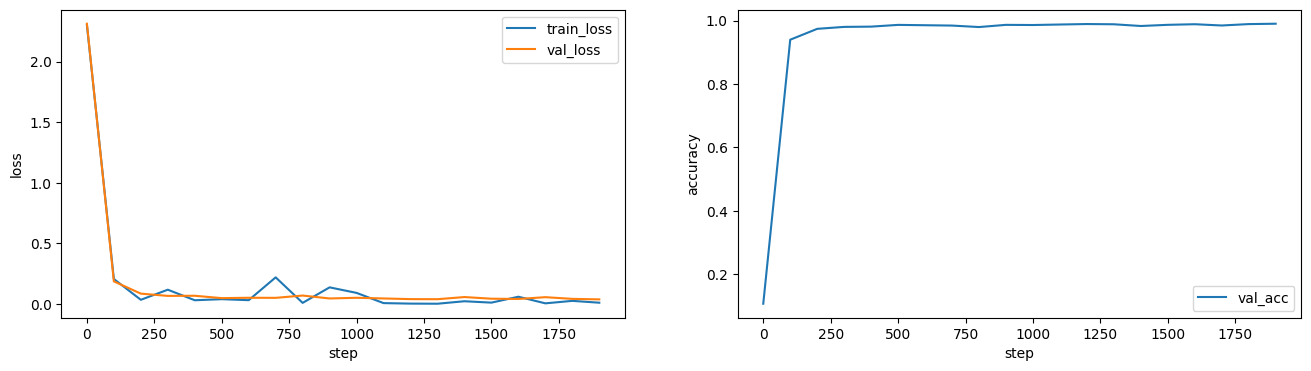

In [9]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='train_loss')
plt.plot(val_stats[:, 0], val_stats[:, 1], label='val_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='val_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()

#### Evaluate the best model

In [10]:
src_model.load_state_dict(torch.load(log_dir/'src_best_model.pth'))

src_loss, src_acc = evaluate(src_model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(src_model, tgt_test, nn.CrossEntropyLoss())

print('Source-only model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

Source-only model:
src_test -> loss: 0.0282, acc: 0.9911
tgt_test -> loss: 0.7416, acc: 0.7519


### Step 2. Train the target encoder

The target encoder is initialized with the weights of the source encoder from the source classifier. Then, it is trained with the following adversarial objective:
$$\begin{align*}
\min_{M_t} \max_{D} \ \mathcal{L}_{adv}(M_s, M_t, D) &= \mathbb{E}_{x_s \sim p_s(x)}[\log D(M_s(x_s))] + \mathbb{E}_{x_t \sim p_t(x)}[\log(1 - D(M_t(x_t)))]
\end{align*}$$
where $M_s$ and $M_t$ are the source and target encoders respectively, and $D$ is the discriminator. Furthermore, note that in this case we are fixing $M_s$ and only optimizing w.r.t. $M_t$ and $D$.

Under this objective, the discriminator $D$ tries to distinguish between the source and target features produced by $M_s$ and $M_t$, while the target encoder $M_t$ tries to fool the discriminator by generating features that align with the source domain features outputted by $M_s$.

#### Initialize the target encoder, classifier, and discriminator

In [11]:
tgt_model = _base_model.CNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

# initialize tgt encoder and classifier with src classifier weights
# this initializes both the encoder and classifier (fc layers) in the tgt classifier
tgt_model.load_state_dict(src_model.state_dict())

# freeze the source model
for param in src_model.parameters():
    param.requires_grad = False

# freeze the target cls_head
for param in tgt_model.cls_head.parameters():
    param.requires_grad = False

# initialize the discriminator
discriminator = _base_model.FCHead(
    input_shape=tgt_model.encoder.output_shape,
    op_out_features=2,
).to(device)

#### Train the target encoder adversarially

In [12]:
def train_tgt_encoder(
    src_model,
    tgt_model,
    discriminator,
    src_train_loader,
    tgt_train_loader,
    tgt_val_loader,
    loss_fn,
    tgt_model_optim,
    discriminator_optim,
    num_steps=20000,
    checkpoint=100,
):
    src_model.train()
    tgt_model.train()
    discriminator.train()

    train_stats = []
    val_stats = []
    best_val_loss = float('inf')

    tb_writer = SummaryWriter(log_dir=log_dir)
    src_train_iter = iter(src_train_loader)
    tgt_train_iter = iter(tgt_train_loader)

    for step in tqdm(range(num_steps)):
        try:
            src_x, _ = next(src_train_iter)
        except StopIteration:
            src_train_iter = iter(src_train_loader)
            src_x, _ = next(src_train_iter)
        try:
            tgt_x, _ = next(tgt_train_iter)
        except StopIteration:
            tgt_train_iter = iter(tgt_train_loader)
            tgt_x, _ = next(tgt_train_iter)
        
        src_x = src_x.to(device)
        tgt_x = tgt_x.to(device)

        # udpate the discriminator
        _, src_features = src_model(src_x)
        _, tgt_features = tgt_model(tgt_x)

        # src features are labeled as 1, tgt features are labeled as 0
        src_labels = torch.full((src_x.shape[0],), fill_value=1, dtype=torch.long, device=device)
        tgt_labels = torch.full((tgt_x.shape[0],), fill_value=0, dtype=torch.long, device=device)

        src_preds = discriminator(src_features.detach())
        tgt_preds = discriminator(tgt_features.detach())

        D_src_loss = loss_fn(src_preds, src_labels)
        D_tgt_loss = loss_fn(tgt_preds, tgt_labels)
        D_loss = D_src_loss + D_tgt_loss

        discriminator_optim.zero_grad()
        D_loss.backward()
        discriminator_optim.step()

        # update the target encoder

        # tgt encoder tries to fool the discriminator by making it output 1 for tgt features
        tgt_labels = torch.full((tgt_x.shape[0],), fill_value=1, dtype=torch.long, device=device)
        tgt_preds = discriminator(tgt_features)

        Mt_loss = loss_fn(tgt_preds, tgt_labels)

        tgt_model_optim.zero_grad()
        Mt_loss.backward()
        tgt_model_optim.step()

        if checkpoint and step % checkpoint == 0:
            val_loss, val_acc = evaluate(tgt_model, tgt_val_loader, loss_fn)

            train_stats += [[step, D_src_loss.item(), D_tgt_loss.item(), Mt_loss.item()]]
            val_stats += [[step, val_loss, val_acc]]

            tb_writer.add_scalar('adapt/adv_loss/D_src', D_src_loss.item(), step)
            tb_writer.add_scalar('adapt/adv_loss/D_tgt', D_tgt_loss.item(), step)
            tb_writer.add_scalar('adapt/adv_loss/Mt', Mt_loss.item(), step)

            tb_writer.add_scalar('adapt/val/tgt_loss', val_loss, step)
            tb_writer.add_scalar('adapt/val/tgt_acc', val_acc, step)

            # save the best model
            # this may be cheating since in reality the target dataset is unlabeled
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(tgt_model.state_dict(), log_dir/'tgt_best_model.pth')
    
    tb_writer.close()

    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

In [13]:
train_stats, val_stats = train_tgt_encoder(
    src_model,
    tgt_model,
    discriminator,
    src_train,
    tgt_train,
    tgt_val,
    nn.CrossEntropyLoss(),
    torch.optim.Adam(tgt_model.parameters(), lr=1e-4, betas=(0.5, 0.9)),
    torch.optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.9)),
    num_steps=5000,
    checkpoint=100,
)

100%|██████████| 5000/5000 [04:04<00:00, 20.46it/s]


#### Learning curves

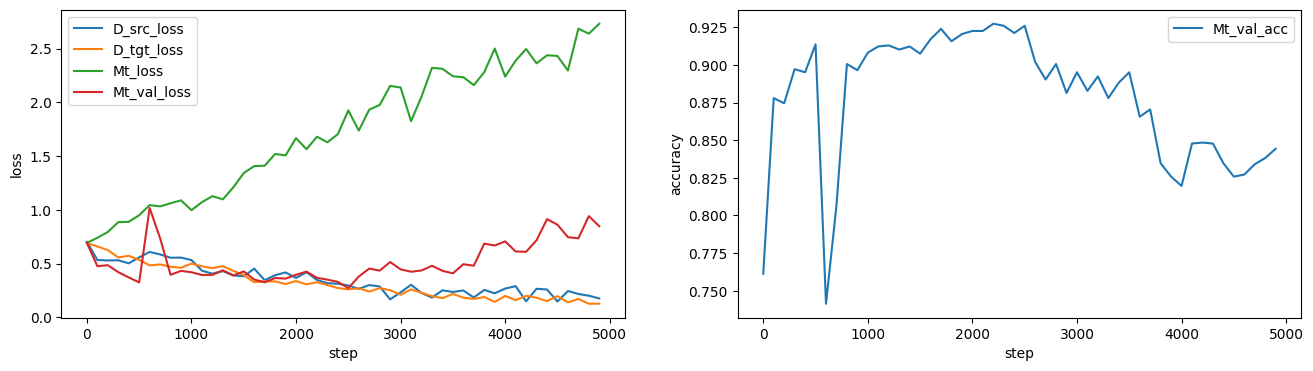

In [14]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='D_src_loss')
plt.plot(train_stats[:, 0], train_stats[:, 2], label='D_tgt_loss')
plt.plot(train_stats[:, 0], train_stats[:, 3], label='Mt_loss')
plt.plot(val_stats[:, 0], val_stats[:, 1], label='Mt_val_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='Mt_val_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()

### Step 3. Combine the target encoder and the source classifier

The combination of the target encoder and the source classifier has already been done in the previous step through weight copying. We can now evaluate the overall classifier on the target domain.

#### Evaluate the best model

In [15]:
tgt_model.load_state_dict(torch.load(log_dir/'tgt_best_model.pth'))

src_loss, src_acc = evaluate(tgt_model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(tgt_model, tgt_test, nn.CrossEntropyLoss())

print('Adapted model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

Adapted model:
src_test -> loss: 0.4051, acc: 0.9173
tgt_test -> loss: 0.3629, acc: 0.9088
